In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import load_iris
import sys
sys.path.append('/Users/takahashiakira/Documents/DIC/diveintocode-ml/ ml-scratch/model')
sys.path.append('/Users/takahashiakira/Documents/DIC/diveintocode-ml/ ml-scratch/utils')
from decision_region import decision_region2
from split import train_test_split

In [2]:
#カーネル関数
def _linear_kernel(xi,xj):
    """
    線形カーネル関数

    Parameters
    ----------
    xi : 次の形のndarray, shape (1, n_features)
      学習データ
    xj:次の形のndarray, shape (1,n_features)    
     学習データ

    Returns
    -------
    output :次の形のndarray, shape (1, 1)
      線形カーネルによるoutput
    
    """
    #outputの算出。
    return np.dot(xi, xj.T)

In [3]:
class ScratchSVMClassifier():
    """
    SVMのスクラッチ実装
    
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    Attributes
    ----------
    X_sup :サポートベクトルの特徴量
    y_sup:サポートベクトルの正解ラベル
    """

    def __init__(self, kernel='poly', num_iter=500, lr=1e-4, C=1, gamma=1, d=2, alpha=1, lam_thre=1e-5):
        #様々なパラメータを初期化
        self.kernel = kernel #カーネルの種類
        self.iter = num_iter #訓練回数
        self.lr = lr #学習率
        self.C = C #ハイパーパラメータ。罰則項。
        self.lam_thre = lam_thre #lamdaの閾値
        self.gamma = gamma # 多項式カーネルのときのハイパーパラメータ
        self.d = d #多項式カーネルの時のハイパーパラメータ 。何乗するか
        self.alpha = alpha #多項式カーネルのときのハイパーパラメータ 　切片的な
    
    #カーネル関数
    def _linear_kernel(self,Xi,Xj):
        """
        線形カーネル関数

        Parameters
        ----------
        Xi:次の形のndarray, shape (n_sample,n_features)    
         学習データ        
         Xi:次の形のndarray, shape (n_sample,n_features)    
         学習データ
         
        Returns
        -------
        output :次の形のndarray, shape (n_sample, n_samples)
          線形カーネルによるoutput

        """
        return np.dot(Xi,Xj.T) 

    def _polynomial_kernel(self,Xi, Xj):
        """
        多項式カーネル関数

        Parameters
        ---------
        Xi:次の形のndarray, shape (n_sample,n_features)    
         学習データ
        Xj:次の形のndarray, shape (n_sample,n_features)    
         学習データ
        γ: gamma float スカラー
        d :int次元数
        theta0 :float主見つけパラメータ 

        Returns
        -------
        output :次の形のndarray, shape (n_sample, n_sample)
          多項式カーネルによるoutput

        """
        return  self.gamma * (np.dot(Xi, Xj.T) + self.alpha) ** self.d

    #ラグランジェ(勾配)
    def _lagrange(self, lamda, X, y, k_out):
        """
        最急降下法の計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples,n_features)
        説明変数
        lamda : 次の形のndarray, shape (n_samples,)
        仮のラグランジェ乗数
        k_out : 次の形のndarray, shape (n_samples,n_samples)
        カーネル関数の出力結果
        y : 次の形のndarray, shape (n_samples,)
        正解ラベル
        
        returns
        ----------
        lamda : 次の形のndarray, shape (n_samples,)
        更新後のパラメータ
        """      
        koubai = 1 - (y * np.sum(k_out * y * lamda, axis=1)) #勾配部分の計算
        lamda = lamda + self.lr * koubai #勾配と学習率をかけてlamdaを更新する。
        lamda = np.where(lamda < self.lam_thre , 0,lamda) #gammaの数値が閾値より低い場合は0に変換
        lamda = np.where(lamda > self.C , 0,lamda) #Cの数値がCより高い場合は0に変換
        return lamda
    
    def fit(self, X, y, kernel='poly', num_iter=500, lr=1e-4, C=1.0, gamma=1, d=2, alpha=1, lam_thre=1e-5, seed=None):
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        
        """
        #様々なパラメータを初期化
        self.kernel = kernel #カーネルの種類
        self.iter = num_iter #訓練回数
        self.lr = lr #学習率
        self.C = C #ハイパーパラメータ。罰則項。
        self.lam_thre = lam_thre #lamdaの閾値
        self.gamma = gamma # 多項式カーネルのときのハイパーパラメータ
        self.d = d #多項式カーネルの時のハイパーパラメータ 。何乗するか
        self.alpha = alpha #多項式カーネルのときのハイパーパラメータ 　切片的な
        np.random.seed(seed) # 初期lamdaのランダムシード
        lamda = np.random.rand(len(X)) #仮lamdaを作成

        #学習開始
        if self.kernel == 'poly': #多項式カーネル
            for i in range(self.iter):
                k_out = self._polynomial_kernel(X,X) #カーネル関数をまず通す
                lamda = self._lagrange(lamda,X, y, k_out) #lamdaの更新
        elif self.kernel == 'linear': #線形カーネル
            for i in range(self.iter):
                k_out = self._linear_kernel(X,X) #カーネル関数をまず通す
                lamda = self._lagrange(lamda,X,y, k_out) #lamdaの更新
        self.X_sup = X[lamda != 0]         #gammaが決まったらサポートベクタのX、ｙをそれぞれ取得
        self.y_sup = y[lamda != 0]         #gammaが決まったらサポートベクタのX、ｙをそれぞれ取得
        self.lamda = lamda[lamda != 0]     #gammaが決まったらサポートベクタのX、ｙをそれぞれ取得
        
        self.w = np.dot(self.lamda * self.y_sup, self.X_sup) #重みの算出(使わない)
        self.w0 = (self.y_sup-np.sum(self.w * self.X_sup,axis=1)).sum()/len(self.y_sup)#切片を算出(使わない)
        
    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        pred:  次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        #カーネル関数にサポートベクトルのみ通す
        if self.kernel == 'poly': #多項式カーネルの場合のoutput
            k_out = self._polynomial_kernel(self.X_sup,X) 
        elif self.kernel == 'linear': #線形カーネルの場合
            k_out = self._linear_kernel(self.X_sup,X)
        pred = np.dot(self.lamda * self.y_sup, k_out)
        pred = np.where(pred < 0,-1,1) #予測したラベルを−１と１に分ける。
        return pred

アイリスを使ってクラスを使ってみる、

In [4]:
#データをロード
data = load_iris()
X = pd.DataFrame(data.data,columns=data.feature_names) #特徴量をdfとして作成
y = pd.DataFrame(data.target,columns=['Species']) #ターゲットをdfとして作成
df = X.join(y) #Xとyを結合
df = df[df.Species != 2].reset_index(drop=True)
X = df.drop('Species',axis=1).values
y = df.Species.values
X = X[:,:2] #２つの特徴量のみを使う
y = np.where(y==0,-1,y) #yを-1,１に変換
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

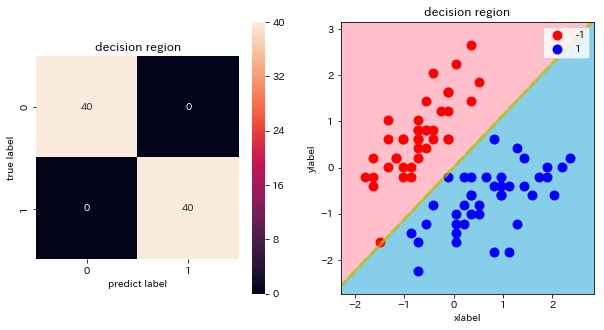

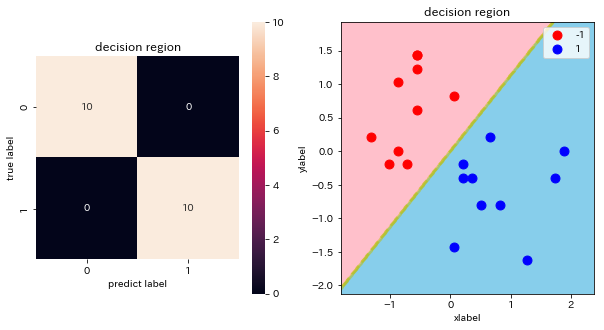

,f1-score,precision,recall,support
-1,1.000,1.000,1.000,10.000
1,1.000,1.000,1.000,10.000
micro avg,1.000,1.000,1.000,20.000
macro avg,1.000,1.000,1.000,20.000
weighted avg,1.000,1.000,1.000,20.000


In [5]:
#インスタンス化
svc = ScratchSVMClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, scaler=True, seed=0) #標準化と、訓練、検証データに分ける。
svc.fit(X_train, y_train, lr=1e-4, lam_thre=1e-4, num_iter=1000, kernel='linear',seed=0)
decision_region2(X_train=X_train, y_train=y_train, model=svc)
decision_region2(X_train=X_test, y_train=y_test, model=svc)

いい感じになったのでskleanのクラスと比較してみる。

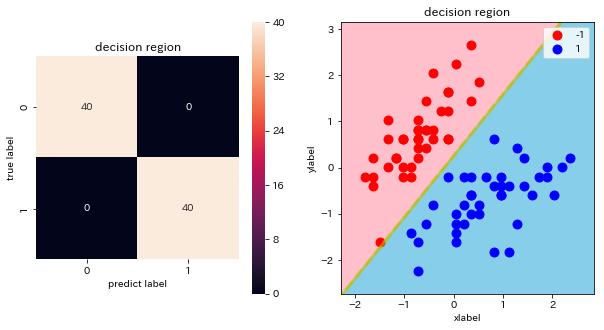

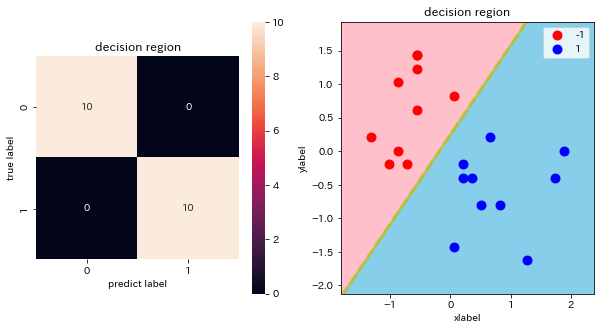

,f1-score,precision,recall,support
-1,1.000,1.000,1.000,10.000
1,1.000,1.000,1.000,10.000
micro avg,1.000,1.000,1.000,20.000
macro avg,1.000,1.000,1.000,20.000
weighted avg,1.000,1.000,1.000,20.000


In [6]:
svc2 = SVC(kernel='linear')
svc2.fit(X_train,y_train)

decision_region2(X_train=X_train, y_train=y_train, model=svc2)
decision_region2(X_train=X_test, y_train=y_test, model=svc2)

ほぼほぼ同様の結果となった。

サポートベクターを見えるようにしてみる。
内部の関数を変更する必要がるので、関数を持ってくる。

In [7]:
#3値分類用に決定領域の関数を変更する。
#混合行列も合わせて可視化する
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
pd.options.display.precision = 4
pd.options.display.float_format = '{:.3f}'.format

def decision_region3(X_train, y_train, model,sup_v, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names= '' ,plot=True):
    """
    3値分類または2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples,)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    #予測
    y_pred1 = model.predict(X_train)
    if target_names == '':
        target_names = np.unique(y_train)

    #指標をdfにまとめる
    report = pd.DataFrame(classification_report(y_train,y_pred1,output_dict=True,target_names=target_names)).T

    #可視化
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    #混合行列も可視化する
    cm = confusion_matrix(y_train,y_pred1)
    sns.heatmap(cm,annot=True,square=True,ax=ax[0])
    ax[0].set_title(title)
    ax[0].set_xlabel('predict label')
    ax[0].set_ylabel('true label')

    if plot==True:
        if len(np.unique(y_train)) == 3:# setting
            scatter_color = ['red', 'blue','green']
            contourf_color = ['pink', 'skyblue','lightgreen']
            n_class = 3
        else:
            scatter_color = ['red', 'blue']
            contourf_color = ['pink', 'skyblue']
            n_class = 2

        # pred
        mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
        mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
        pred = model.predict(mesh).reshape(mesh_f0.shape)

        # plot
        ax[1].set_title(title)
        ax[1].set_xlabel(xlabel)
        ax[1].set_ylabel(ylabel)
        ax[1] = plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
        ax[1] = plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
        for i, target in enumerate(np.unique(y_train)):
            ax[1] = plt.scatter(X_train[(y_train==target).flatten()][:, 0],
            X_train[(y_train==target).flatten()][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
        patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
        ax[1] = plt.legend(handles=patches)
        ax[1] = plt.legend()
        ax[1] = plt.scatter(x=sup_v[:,0],y=sup_v[:,1],c='y')
        plt.show()
    return report


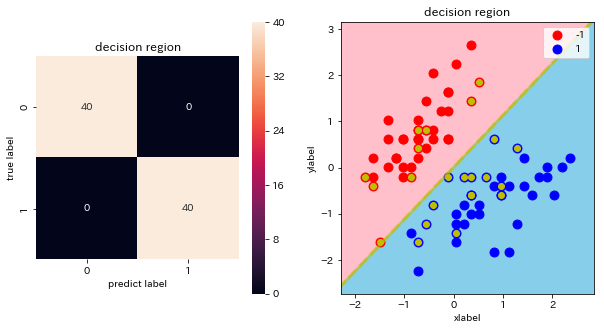

,f1-score,precision,recall,support
-1,1.000,1.000,1.000,40.000
1,1.000,1.000,1.000,40.000
micro avg,1.000,1.000,1.000,80.000
macro avg,1.000,1.000,1.000,80.000
weighted avg,1.000,1.000,1.000,80.000


In [8]:
#インスタンス化
svc = ScratchSVMClassifier()
svc.fit(X_train, y_train, lr=1e-4, lam_thre=1e-4, num_iter=1000,  kernel='linear',seed=0)
y_pred = svc.predict(X_test)
decision_region3(X_train=X_train, y_train=y_train, sup_v=svc.X_sup, model=svc)

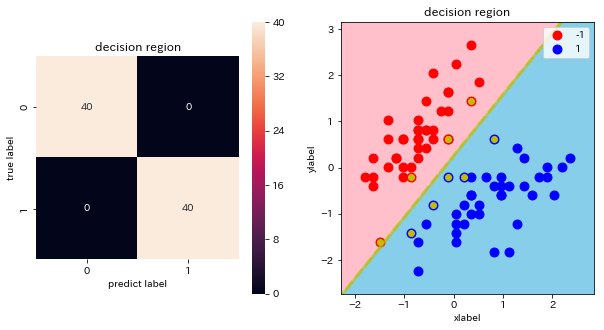

,f1-score,precision,recall,support
-1,1.000,1.000,1.000,40.000
1,1.000,1.000,1.000,40.000
micro avg,1.000,1.000,1.000,80.000
macro avg,1.000,1.000,1.000,80.000
weighted avg,1.000,1.000,1.000,80.000


In [9]:
#sklearnでも試す。
svc2 = SVC(kernel='linear')
svc2.fit(X_train, y_train)
decision_region3(X_train=X_train, y_train=y_train, sup_v=svc2.support_vectors_, model=svc2)

ほぼほぼ同様の結果なので多分大丈夫

# 【問題2】（アドバンス課題）多項式カーネル関数の作成

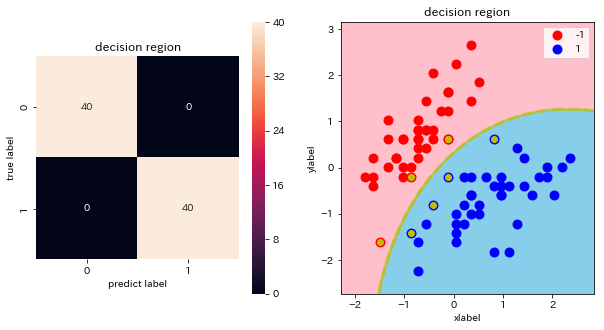

,f1-score,precision,recall,support
-1,1.000,1.000,1.000,40.000
1,1.000,1.000,1.000,40.000
micro avg,1.000,1.000,1.000,80.000
macro avg,1.000,1.000,1.000,80.000
weighted avg,1.000,1.000,1.000,80.000


In [10]:
#インスタンス化
svc3 = ScratchSVMClassifier()
svc3.fit(X_train, y_train, lr=1e-2, lam_thre=1e-3, num_iter=1000, d=2, gamma=1, alpha=1, kernel='poly',seed=0)
decision_region3(X_train=X_train, y_train=y_train, sup_v=svc3.X_sup, model=svc3)

Cの変化

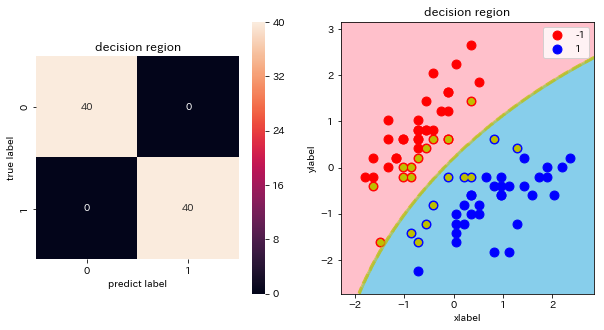

,f1-score,precision,recall,support
-1,1.000,1.000,1.000,40.000
1,1.000,1.000,1.000,40.000
micro avg,1.000,1.000,1.000,80.000
macro avg,1.000,1.000,1.000,80.000
weighted avg,1.000,1.000,1.000,80.000


In [11]:
#インスタンス化
svc3 = ScratchSVMClassifier()
svc3.fit(X_train, y_train, lr=1e-2, lam_thre=1e-3, num_iter=1000, d=2, gamma=1, alpha=1, kernel='poly',C=0.2, seed=0)
decision_region3(X_train=X_train, y_train=y_train, sup_v=svc3.X_sup, model=svc3)

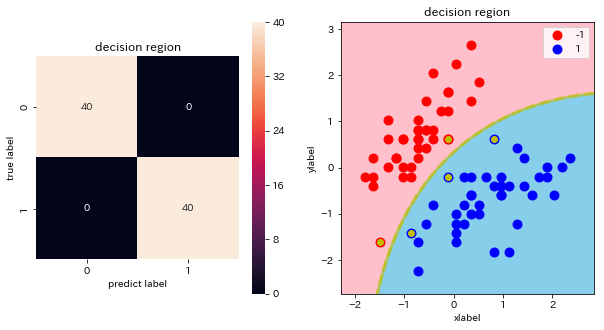

,f1-score,precision,recall,support
-1,1.000,1.000,1.000,40.000
1,1.000,1.000,1.000,40.000
micro avg,1.000,1.000,1.000,80.000
macro avg,1.000,1.000,1.000,80.000
weighted avg,1.000,1.000,1.000,80.000


In [12]:
svc4 = SVC(kernel='poly',degree=2,coef0=2,C=1e10)
svc4.fit(X_train,y_train)
decision_region3(X_train=X_train,y_train=y_train,sup_v=svc4.support_vectors_,model=svc4)

sklearnと結果が近くてとてもいい！

# 【問題3】指標値の算出

# 【問題4】決定領域の可視化

シンプルデータセット１に対しての処理

In [13]:
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

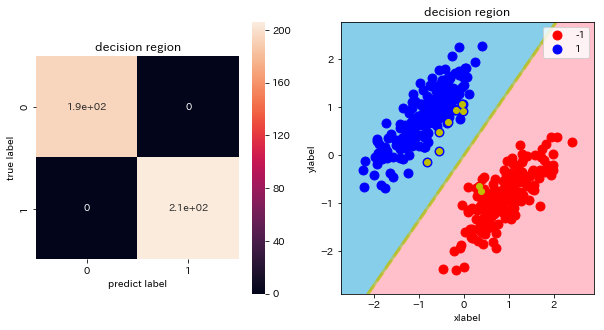

,f1-score,precision,recall,support
-1,1.000,1.000,1.000,194.000
1,1.000,1.000,1.000,206.000
micro avg,1.000,1.000,1.000,400.000
macro avg,1.000,1.000,1.000,400.000
weighted avg,1.000,1.000,1.000,400.000


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, scaler=True, seed=0) #標準化と、訓練、検証データに分ける。
#インスタンス化
svc3 = ScratchSVMClassifier()
svc3.fit(X_train, y_train, lr=1e-3, lam_thre=1e-2, num_iter=1000, kernel='linear', seed=0, C=1e10)
decision_region3(X_train=X_train, y_train=y_train, sup_v=svc3.X_sup, model=svc3)

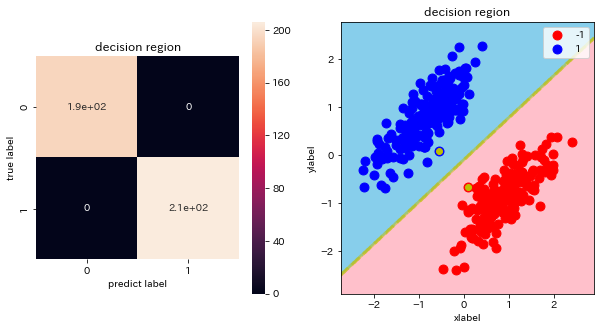

,f1-score,precision,recall,support
-1,1.000,1.000,1.000,194.000
1,1.000,1.000,1.000,206.000
micro avg,1.000,1.000,1.000,400.000
macro avg,1.000,1.000,1.000,400.000
weighted avg,1.000,1.000,1.000,400.000


In [15]:
svc4 = SVC(kernel='linear', C=1e10)
svc4.fit(X_train, y_train)
decision_region3(X_train=X_train, y_train=y_train, sup_v=svc4.support_vectors_, model=svc4)

# 【問題5】時間の計測

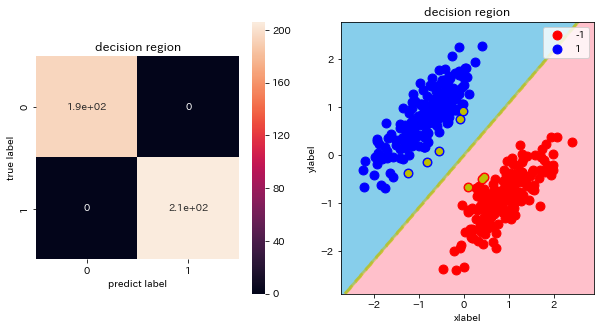

1万回のトレーニングを重ねて、そのまま可視化する作業 is time : 5.217422962188721s


In [16]:
#線形カーネルの場合
import time
t0 = time.time()
#インスタンス化
svc3 = ScratchSVMClassifier()
svc3.fit(X_train, y_train, lr=0.009, lam_thre=1e-4, num_iter=10000, kernel='linear', seed=0)
decision_region3(X_train=X_train, y_train=y_train, sup_v=svc3.X_sup, model=svc3)
t1 = time.time()
print('1万回のトレーニングを重ねて、そのまま可視化する作業 is time : {}s'.format(t1-t0))

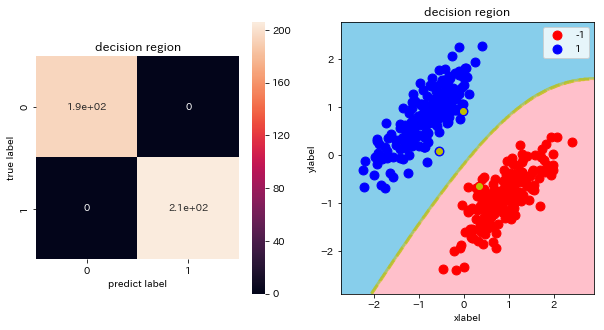

1万回のトレーニングを重ねて、そのまま可視化する作業 is time : 6.656301259994507s


In [17]:
#ポリの場合
t0 = time.time()
#インスタンス化
svc3 = ScratchSVMClassifier()
svc3.fit(X_train, y_train, lr=1e-3, lam_thre=1e-3, num_iter=10000, d=2, alpha=1, kernel='poly', seed=0)
decision_region3(X_train=X_train, y_train=y_train, sup_v=svc3.X_sup, model=svc3)
t1 = time.time()
print('1万回のトレーニングを重ねて、そのまま可視化する作業 is time : {}s'.format(t1-t0))

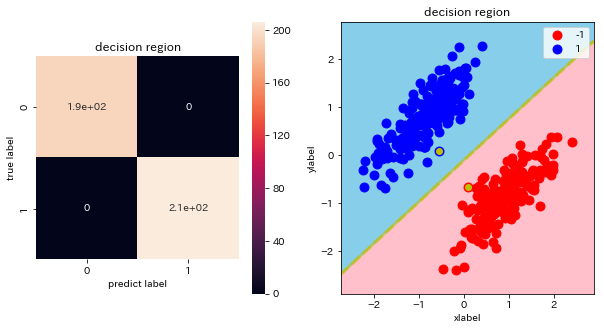

sklearnの時間 何回トレーニングしてるのかは不明 is time : 0.42148518562316895s


In [18]:
#sklearnの場合
t0 = time.time()
svc4 = SVC(kernel='poly', degree=2, coef0=2, C=1e10)
svc4.fit(X_train, y_train)
decision_region3(X_train=X_train, y_train=y_train, sup_v=svc4.support_vectors_, model=svc4)
t1 = time.time()
print('sklearnの時間 何回トレーニングしてるのかは不明 is time : {}s'.format(t1-t0))

# 【問題6】ロジスティック回帰とSVM

- ロジスティック回帰は仮定関数にてシグモイド関数を使って出力を確率としてふるまわせて、実際のクラス全ての差を誤差としてその誤差を最小化させていく
- SVMはマージンを最大化するためのサポートベクタと超平面を決める。ロジスティック回帰と比較すると、境界から遠いデータには影響を受けづらい。(サポートベクタとして残らないから？)
- カーネル関数の導入や、ソフトマージンの考え方により多様な関数への近似することができ、線形分離不可能な問題にも対応することができる